# **Projet Python pour la Data Science**
### **Modélisation des valeurs du CAC40 à partir des politiques de la BCE**
Dans ce projet Python pour la Data Science, nous cherchons à produire un modèle de prédiction des valeurs du CAC40, en fonction de données économiques (PIB, chômage, inflation, confiance...) et des politiques de la Banque Centrale Européenne. 

Notre travail s'est décliné en plusieurs étapes : 

- Définir nos variables explicatives, les importer depuis Internet grâce à leur URL
- Nettoyer ces données pour les rendre exploitables
- Analyser ces données
- Trouver le modèle pertinent pour expliquer l'influence des variables sur les valeurs du CAC40

## **Sommaire**

- [Installation](#Installation)
- [Récupération des données](#Récupération-des-données)
- [Nettoyage des données](#Nettoyage-des-données)
- [Analyse des données](#Analyse-des-données)
- [Modélisations](#Modélisation)
    - [Modélisation du CAC 40 à partir des variables macroéconomiques](#Modélisation-du-CAC-40-à-partir-des-variables-macroéconomiques)
    - [Modélisation des effets des politiques monétaires sur le CAC 40](#Modélisation-des-effets-des-politiques-monétaires-sur-le-CAC-40)
- [Résultats et conclusion](#Résultats-et-conclusion)

## **Installation** 
Importation des libraries et installation des modules nécessaires.


In [1116]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
import requests
import zipfile
import pandas as pd
import nettoyage as nt
import recuperation as rc
import analyse as an

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from io import BytesIO

!pip install openpyxl
!pip install yfinance
!pip install jupyter_contrib_nbextensions

## **Récupération des données**

### **Données du CAC 40**
Nous utilisons l'API yfinance afin de récupérer les données et les rassembler dans un fichier CSV.

In [1117]:
import yfinance as yf

CAC40_y = "^FCHI"  
dfcac40 = yf.download(CAC40_y, start="2000-01-01", interval="3mo")

dfcac40.to_csv("cac40_trimestre.csv")
cac40 = pd.read_csv("cac40_trimestre.csv")

[*********************100%***********************]  1 of 1 completed


### **Données de la BCE** 
##### **Nous utilisons l'API SDW de la BCE pour récupérer l'historique des taux directeurs depuis 2000 que nous sauvegardons dans un fichier CSV.**

In [1118]:
import requests
import pandas as pd

def fetch_ecb_interest_rates():
    # Liste des codes des séries SDW pour les taux directeurs
    series_codes = {
        "Main Refinancing Operations (MRO)": "FM.B.U2.EUR.4F.KR.MRR_FR.LEV",
        "Deposit Facility Rate (DFR)": "FM.B.U2.EUR.4F.KR.DFR.LEV",
        "Marginal Lending Facility (MLF)": "FM.B.U2.EUR.4F.KR.MLF.LEV",
    }

    # Initialisation des résultats
    all_rates = []

    for rate_name, series_code in series_codes.items():
        # Construire l'URL pour chaque série
        url = f"https://sdw-wsrest.ecb.europa.eu/service/data/{series_code}?detail=dataonly"

        headers = {
            "Accept": "application/vnd.sdmx.data+json;version=1.0.0-wd",
        }

        response = requests.get(url, headers=headers)

        if response.status_code != 200:
            print(f"Erreur lors de la requête pour {rate_name}: {response.status_code}")
            continue

        # Analyse des données JSON
        data = response.json()
        series = data['dataSets'][0]['series']['0:0:0:0:0']
        time_periods = data['structure']['dimensions']['observation'][0]['values']

        # Extraire les dates et taux
        for index, obs in series['observations'].items():
            date = time_periods[int(index)]['id']
            value = obs[0]
            all_rates.append({"Rate Type": rate_name, "Date": date, "Value": value})

    # Conversion en DataFrame
    df = pd.DataFrame(all_rates)

    # Sauvegarder dans un fichier CSV
    csv_file = "ecb_interest_rates.csv"
    df.to_csv(csv_file, index=False)
    print(f"Données sauvegardées dans {csv_file}")

# Appel de la fonction
fetch_ecb_interest_rates()


Erreur lors de la requête pour Main Refinancing Operations (MRO): 400
Erreur lors de la requête pour Deposit Facility Rate (DFR): 400
Erreur lors de la requête pour Marginal Lending Facility (MLF): 400
Données sauvegardées dans ecb_interest_rates.csv


### **Variables macroéconomiques**
Nous récupérons les données sur internet à partir des liens URL des sites hébergeant les données. 

In [1119]:
def url_df(url, excel_name=None, sheet_name=None, save_as_csv=False, csv_name="output.csv"):
    try:
        response = requests.get(url)  # Télécharge le fichier
        response.raise_for_status()
        
        # Vérifie si c'est un zip
        content_type = response.headers.get('Content-Type', '').lower()
        if 'zip' in content_type or url.endswith('.zip'):
            print("Le fichier téléchargé est un fichier zip.")
            zip_content = BytesIO(response.content)
            with zipfile.ZipFile(zip_content) as zip:  # Corrigé ici

                if excel_name is None:
                    excel_name = next((f for f in zip.namelist() if f.endswith('.xlsx')), None)
                    if excel_name is None:
                        raise FileNotFoundError("Aucun fichier Excel trouvé dans le zip.")
                    print(f"Fichier Excel non spécifié, utilisation de : {excel_name}.")
                
                if excel_name not in zip.namelist():
                    raise FileNotFoundError(f"Le fichier '{excel_name}' est introuvable dans le zip.")
                
                with zip.open(excel_name) as excel:
                    excel_data = pd.ExcelFile(BytesIO(excel.read())) 
        
        # Si ce n'est pas un zip, on suppose que c'est un fichier Excel
        elif 'excel' in content_type or url.endswith('.xlsx'):
            print("Le fichier téléchargé est un fichier Excel.")
            excel_data = pd.ExcelFile(BytesIO(response.content))
        
        else:
            raise ValueError("Le fichier téléchargé n'est ni un fichier Excel, ni un fichier zip.")
        
        if sheet_name is None:
            sheet_name = excel_data.sheet_names[0]
            print(f"Feuille non spécifiée, chargement de : {sheet_name}")
        
        # Création d'un dataframe
        df = excel_data.parse(sheet_name)
        print(f"Feuille '{sheet_name}' chargée.")
        
        # Sauvegarde en CSV si demandé
        if save_as_csv:
            df.to_csv(csv_name, index=False, encoding='utf-8-sig')
            print(f"Fichier sauvegardé au format CSV sous le nom : {csv_name}")
        
        return df
    
    except Exception as e:
        print(f"Erreur : {e}")
        return None


In [1120]:
chomage = url_df("https://www.insee.fr/fr/statistiques/fichier/2532173/econ-gen-taux-cho-trim-2.xlsx", None, None, save_as_csv=True, csv_name="chomage.csv")
confiance = url_df("https://www.insee.fr/en/statistiques/serie/telecharger/xlsx/001587668?ordre=antechronologique&transposition=donneesligne&periodeDebut=10&anneeDebut=1972&periodeFin=11&anneeFin=2024&revision=sansrevisions", None, None, save_as_csv=True, csv_name="confiance.csv")
ev_pib = url_df("https://www.insee.fr/fr/statistiques/fichier/2830547/econ-gen-pib-composante-trim.xlsx", None, None, save_as_csv=True, csv_name="ev_pib.csv")
ipc = url_df("https://www.insee.fr/fr/statistiques/serie/telecharger/xlsx/001759970?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1990&periodeFin=11&anneeFin=2024&revision=sansrevisions", None, None, save_as_csv=True, csv_name="ipc.csv")

Le fichier téléchargé est un fichier Excel.
Feuille non spécifiée, chargement de : Données
Feuille 'Données' chargée.
Fichier sauvegardé au format CSV sous le nom : chomage.csv
Le fichier téléchargé est un fichier zip.
Fichier Excel non spécifié, utilisation de : serie_001587668_29122024.xlsx.
Feuille non spécifiée, chargement de : monthly_values
Feuille 'monthly_values' chargée.
Fichier sauvegardé au format CSV sous le nom : confiance.csv
Le fichier téléchargé est un fichier Excel.
Feuille non spécifiée, chargement de : Données
Feuille 'Données' chargée.
Fichier sauvegardé au format CSV sous le nom : ev_pib.csv


/opt/conda/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Le fichier téléchargé est un fichier zip.
Fichier Excel non spécifié, utilisation de : serie_001759970_29122024.xlsx.
Feuille non spécifiée, chargement de : valeurs_mensuelles
Feuille 'valeurs_mensuelles' chargée.
Fichier sauvegardé au format CSV sous le nom : ipc.csv


/opt/conda/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## **Nettoyage des données**


### **Nettoyage des données sur le CAC 40**

Nous cherchons à éliminer les données inutile à notre analyse. Pour cela, nous ouvrons la base de données et nettoyons les colonnes. Nous avons décidé de conserver seulement la colonne Close de l'indicateur trimestriel du CAC 40. 

In [1121]:
cac40.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,^FCHI,^FCHI,^FCHI,^FCHI,^FCHI
1,Date,NaN,NaN,NaN,NaN,NaN
2,1999-12-01,6190.9599609375,6396.97021484375,5388.85009765625,6024.3798828125,0
3,2000-03-01,6426.259765625,6591.43994140625,5752.43994140625,6272.1298828125,0
4,2000-06-01,6625.419921875,6780.66015625,6354.93017578125,6428.4599609375,0


In [1122]:
cac40.drop(columns=['Volume', 'High', 'Low', 'Open'], inplace=True)
cac40 = cac40.iloc[3:].reset_index(drop=True)
cac40.rename(columns={'Price': 'trimestre'}, inplace=True)
nt.handle_missing_values(cac40)

cac40['trimestre'] = pd.to_datetime(cac40['trimestre'])
# Création du format 2000.T1, 2000.T2...
cac40['trimestre'] = cac40['trimestre'].dt.year.astype(str) + '.T' + ((cac40['trimestre'].dt.month - 1) // 3 + 1).astype(str)

cac40['Close'] = pd.to_numeric(df['Close'], errors='coerce')


### **Nettoyage des données sur le chômage**

In [1123]:
chomage.head()

,Taux de chômage selon le sexe et l'âge,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,en %,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sexe et âge,1975-T1,1975-T2,1975-T3,1975-T4,1976-T1,1976-T2,1976-T3,1976-T4,1977-T1,...,2022-T2,2022-T3,2022-T4,2023-T1,2023-T2,2023-T3,2023-T4,2024-T1,2024-T2,2024-T3
3,Femmes,4.6,4.9,5.2,5.5,5.8,5.9,5.8,5.8,6.1,...,7.2,7,6.9,6.8,7.1,7.4,7.4,7.3,7.4,7.2
4,15-24 ans,9.8,10.4,11.1,11.8,12.8,13.1,12.7,12.6,13.5,...,17.3,15.7,14.8,15.6,16,16,16.7,17,18.2,20


In [1124]:
chomage = chomage.T
chomage = chomage[[2, 11]]
chomage.columns = chomage.iloc[0] 
chomage = chomage[1:]
chomage.rename(columns={"Sexe et âge": "trimestre", "Ensemble ": "taux_chomage"}, inplace=True)
chomage['trimestre'] = chomage['trimestre'].str.replace('-', '.', regex=False)
chomage.columns = ["trimestre", "taux_chomage"]
chomage = chomage.reset_index(drop=True)
nt.handle_missing_values(chomage)
nt.filter_dataframe_by_trimestre(chomage, "2000.T1")

,trimestre,taux_chomage
0,2000.T1,9.1
1,2000.T2,8.7
2,2000.T3,8.4
3,2000.T4,8
4,2001.T1,7.8
...,...,...
94,2023.T3,7.4
95,2023.T4,7.5
96,2024.T1,7.5
97,2024.T2,7.3


### **Nettoyage des données sur la confiance**


In [1125]:
confiance

,Label,idBank,Last update,Period,2024-11,2024-10,2024-09,2024-08,2024-07,2024-06,...,1973-07,1973-06,1973-05,1973-04,1973-03,1973-02,1973-01,1972-12,1972-11,1972-10
0,Monthly consumer confidence survey - Summary i...,1587668,27/11/2024 08:45,NaN,90,93,95,92,91,90,...,127,129,131,131,131,130,130,129,128,127


In [1126]:
# Suppression des colonnes inutiles
confiance.drop(columns=["Label","idBank", "Last update", "Period"])

# On transpose pour travailler sur les index
conf_transpose = confiance.T
conf_transpose.columns = ['Value'] 

# On exclue les valeurs qui ne respectent pas le format AAAA-MM
conf_transpose = conf_transpose[conf_transpose.index.str.match(r'^\d{4}-\d{2}$')]

# On extrait l'année et le mois depuis l'index
conf_transpose['Annee'] = conf_transpose.index.str[:4].astype(int)
conf_transpose['Mois'] = conf_transpose.index.str[-2:].astype(int)

# Création d'une colonne pour le trimestre
conf_transpose['TrimAnnee'] = ((conf_transpose['Mois'] - 1) // 3) + 1

# Calcul des moyennes trimestrielles en groupant par année et trimestre
TrimAnnee_Moyen = (
    conf_transpose
    .groupby(['Annee', 'TrimAnnee'])['Value']
    .mean()
    .reset_index()
)

# Créeation d'un dataframe avec nos données
TrimAnnee_Moyen['trimestre'] = TrimAnnee_Moyen['Annee'].astype(str) + '.T' + TrimAnnee_Moyen['TrimAnnee'].astype(str)
confiance = TrimAnnee_Moyen[['trimestre', 'Value']].rename(columns={'Value': 'indic_confiance'})

nt.filter_dataframe_by_trimestre(confiance, "2000.T1")
nt.handle_missing_values(confiance)


,trimestre,indic_confiance
0,1972.T4,128.0
1,1973.T1,130.333333
2,1973.T2,130.333333
3,1973.T3,126.0
4,1973.T4,122.0
...,...,...
204,2023.T4,87.666667
205,2024.T1,90.666667
206,2024.T2,90.0
207,2024.T3,92.666667


### **Nettoyage des données sur le PIB**


On cherche à isoler des indicateurs pour l'évolution du PIB, la consommation des ménages et des APU, la formation brute de capital fixe, les importations et exportations. On fait le choix de prendre plus d'indicateurs, quitte à les éliminer par la suite.

In [1127]:
ev_pib

,Évolution du produit intérieur brut et de ses composantes,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,par rapport au trimestre précédent en volume en %,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Trimestre,Produit intérieur brut (PIB),Importations,Dépense de consommation des ménages,Dépense de consommation des APU1,Formation brute de capital fixe,dont :,NaN,NaN,Exportations,Contributions :,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Entreprises non financières,ménages,APU1,NaN,Demande intérieure finale hors stocks,Variations de stocks,Commerce extérieur
4,2024-T3,0.38673,-0.589976,0.610828,0.561648,-0.706234,-1.228128,-0.645364,0.539162,-0.758542,0.305012,0.134889,-0.053171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,1. Administrations publiques.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,Note : données révisées ; les volumes sont mes...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,"Lecture : au 3e trimestre 2024, le produit int...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,Champ : France.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1128]:
ev_pib.columns = ev_pib.iloc[2] 
ev_pib = ev_pib[["Trimestre", "Produit intérieur brut (PIB)", "Importations", "Dépense de consommation des ménages", "Dépense de consommation des APU1", "Formation brute de capital fixe", "Exportations" ]]
ev_pib = ev_pib.drop(index=range(0,4))
ev_pib = ev_pib.drop(index=range(306,311))

# Renommer les colonnes à utiliser
ev_pib.rename(columns={'Trimestre': 'trimestre'}, inplace=True)
ev_pib.rename(columns={'Produit intérieur brut (PIB)': 'ev_pib'}, inplace=True) 
ev_pib.rename(columns={'Importations': 'ev_importations'}, inplace=True) 
ev_pib.rename(columns={'Dépense de consommation des ménages': 'ev_conso_menages'}, inplace=True) 
ev_pib.rename(columns={'Dépense de consommation des APU1': 'ev_conso_apu'}, inplace=True) 
ev_pib.rename(columns={'Formation brute de capital fixe': 'ev_fbcf'}, inplace=True) 
ev_pib.rename(columns={'Exportations': 'ev_exportations'}, inplace=True) 
ev_pib['trimestre'] = ev_pib['trimestre'].str.replace('-', '.', regex=False)

#Création d'une variable consommation regroupant la consommation des APU et des ménages
ev_pib['ev_conso'] = ev_pib['ev_conso_menages'] + ev_pib['ev_conso_apu']

#Inversion des colonnes pour avoir des données chronologiques et sélection depuis le premier trimestre de l'année 2000
ev_pib = ev_pib.iloc[::-1].reset_index(drop=True)
nt.handle_missing_values(ev_pib)

2,trimestre,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso
0,1949.T2,0.901743,0.049953,0.892687,0.555926,1.469556,2.978648,1.448613
1,1949.T3,1.49785,-3.904022,2.214727,1.083591,1.26969,0.761173,3.298319
2,1949.T4,1.397159,-4.812921,-0.301375,1.586086,1.027304,2.231508,1.284711
3,1950.T1,2.748324,8.117672,1.540113,2.234306,0.210622,8.074533,3.774419
4,1950.T2,2.525426,-2.028922,2.217541,1.890568,1.595365,3.479008,4.10811
...,...,...,...,...,...,...,...,...
297,2023.T3,0.050172,-0.521755,0.530491,0.532103,-0.075909,-0.921628,1.062594
298,2023.T4,0.447218,-1.973741,0.296367,0.446007,-0.842328,0.705229,0.742375
299,2024.T1,0.208671,0.114719,0.074188,0.692141,-0.599452,0.537697,0.766329
300,2024.T2,0.184356,0.093225,-0.041007,0.5593,-0.132713,0.63906,0.518293


In [1129]:
nt.filter_dataframe_by_trimestre(ev_pib, "2000.T1")

2,trimestre,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso
0,2000.T1,0.983261,4.71687,1.254909,0.606497,2.242933,2.840179,1.861406
1,2000.T2,1.06689,4.200106,0.77803,0.461509,0.917383,4.95979,1.239539
2,2000.T3,0.781831,3.529828,0.441062,0.346496,2.548516,1.415566,0.787557
3,2000.T4,0.562298,2.233236,0.126547,0.159236,0.069402,2.986463,0.285783
4,2001.T1,0.576989,-1.294722,1.144187,0.120101,0.670102,0.403586,1.264287
...,...,...,...,...,...,...,...,...
94,2023.T3,0.050172,-0.521755,0.530491,0.532103,-0.075909,-0.921628,1.062594
95,2023.T4,0.447218,-1.973741,0.296367,0.446007,-0.842328,0.705229,0.742375
96,2024.T1,0.208671,0.114719,0.074188,0.692141,-0.599452,0.537697,0.766329
97,2024.T2,0.184356,0.093225,-0.041007,0.5593,-0.132713,0.63906,0.518293


### **Nettoyage des données sur l'indice des prix à la consommation**


In [1130]:
ipc

,Libellé,Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble,Unnamed: 2
0,idBank,001759970,NaN
1,Dernière mise à jour,13/12/2024 08:45,NaN
2,Période,NaN,Date de parution au JO
3,2024-11,119.72,15/12/2024
4,2024-10,119.89,17/11/2024
...,...,...,...
417,1990-05,67.19,29/06/1990
418,1990-04,67.09,01/06/1990
419,1990-03,66.72,02/05/1990
420,1990-02,66.56,30/03/1990


In [1131]:
ipc = ipc[["Libellé", "Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble"]]
ipc.rename(columns={'Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble': 'ipc_menage'}, inplace=True) 
ipc = ipc.drop(index=range(0,3))
ipc = ipc.iloc[::-1].reset_index(drop=True)

# On extrait l'année et le mois
ipc['Année'] = ipc['Libellé'].str[:4].astype(int)
ipc['Mois'] = ipc['Libellé'].str[5:].astype(int)

# On détermine le trimestre
ipc['trimestre'] = ((ipc['Mois'] - 1) // 3) + 1

# Calcul de la moyenne trimestrielle
ipc['trimestre'] = ipc['Année'].astype(str) + '.T' + ipc['trimestre'].astype(str)
ipc = ipc.groupby('trimestre')['ipc_menage'].mean().reset_index()
nt.handle_missing_values(ipc)

/tmp/ipykernel_59145/1612128764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipc.rename(columns={'Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble': 'ipc_menage'}, inplace=True)


,trimestre,ipc_menage
0,1990.T1,66.566667
1,1990.T2,67.153333
2,1990.T3,67.653333
3,1990.T4,68.33
4,1991.T1,68.803333
...,...,...
135,2023.T4,118.35
136,2024.T1,118.956667
137,2024.T2,120.126667
138,2024.T3,120.346667


In [1132]:
nt.filter_dataframe_by_trimestre(ipc, "2000.T1")

,trimestre,ipc_menage
0,2000.T1,79.36
1,2000.T2,79.813333
2,2000.T3,80.106667
3,2000.T4,80.436667
4,2001.T1,80.396667
...,...,...
95,2023.T4,118.35
96,2024.T1,118.956667
97,2024.T2,120.126667
98,2024.T3,120.346667


### **Création d'un dataframe contenant toutes les datas**
On veut à présent rassembler toutes les données dans un seul tableau indexé par la date en trimestre depuis 2000.

In [1133]:
chomage = chomage[chomage['trimestre'].str.startswith('20')]
ipc = ipc[ipc['trimestre'].str.startswith('20')]
ev_pib = ev_pib[ev_pib['trimestre'].str.startswith('20')]
confiance = confiance[confiance['trimestre'].str.startswith('20')]
cac40 = cac40[cac40['trimestre'].str.startswith('20')]


In [1134]:
chomage['trimestre'] = chomage['trimestre'].str.strip()

In [1135]:
# Fusionner toutes les données dans un seul dataframe
dfs = [cac40, chomage, confiance, ev_pib, ipc]  
df = dfs[0]  # Initialisation avec le premier dataframe

for other_df in dfs[1:]:
    df = df.merge(other_df, on="trimestre", how="outer") 

df.set_index('trimestre', inplace=True)

df

,Close,taux_chomage,indic_confiance,ev_pib,ev_importations,ev_conso_menages,ev_conso_apu,ev_fbcf,ev_exportations,ev_conso,ipc_menage
trimestre,,,,,,,,,,,
2000.T1,NaN,9.1,119.333333,0.983261,4.71687,1.254909,0.606497,2.242933,2.840179,1.861406,79.36
2000.T2,NaN,8.7,123.0,1.06689,4.200106,0.77803,0.461509,0.917383,4.95979,1.239539,79.813333
2000.T3,NaN,8.4,121.0,0.781831,3.529828,0.441062,0.346496,2.548516,1.415566,0.787557,80.106667
2000.T4,NaN,8,121.0,0.562298,2.233236,0.126547,0.159236,0.069402,2.986463,0.285783,80.436667
2001.T1,NaN,7.8,124.0,0.576989,-1.294722,1.144187,0.120101,0.670102,0.403586,1.264287,80.396667
...,...,...,...,...,...,...,...,...,...,...,...
2023.T4,NaN,7.5,87.666667,0.447218,-1.973741,0.296367,0.446007,-0.842328,0.705229,0.742375,118.35
2024.T1,NaN,7.5,90.666667,0.208671,0.114719,0.074188,0.692141,-0.599452,0.537697,0.766329,118.956667
2024.T2,NaN,7.3,90.0,0.184356,0.093225,-0.041007,0.5593,-0.132713,0.63906,0.518293,120.126667


## **Analyse des données**

### **L'indicateur de fermeture du CAC 40**

AttributeError: module 'analyse' has no attribute 'afficher_statistiques'

### **Regression linéaire : prédiction du cac 40 à partir d'indicateurs macroéconomiques**

Première tentative de regression linéaire 

Sélection des variables dépendantes et indépendantes :

In [ ]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1070]:
# Variables indépendantes : toutes les colonnes sauf les valeurs du CAC40 ( 'ev_conso_menages','ev_conso_apu')
X = df[['taux_chomage', 'indic_confiance', 'ev_pib', 'ev_importations', 
         'ev_fbcf', 'ev_exportations', 'ev_conso', 'ipc_menage']]

# Variables dépendantes (on cherche celle qui est la plus pertinente)
y = df['Close']  # ou  'High', 'Low', 'Open' selon

In [1071]:
# On sépare les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

#Coefficients du model
print("Coefficient :", model.coef_)
print("Interception :", model.intercept_)



ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [234]:
# Prédictions
y_pred = model.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations dans l'ensemble de test
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")


RMSE: 486552.0386966692
R²: 0.6729362181799243
R² ajusté: 0.43507164958350575


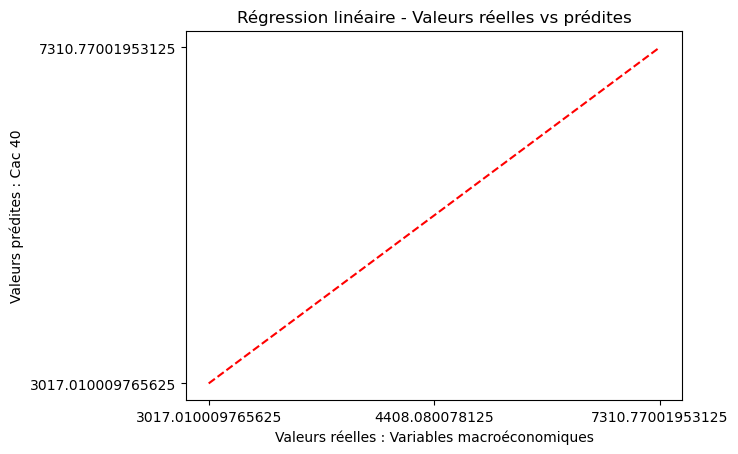

In [235]:
import matplotlib.pyplot as plt

# Affichage des valeurs réelles vs prédites
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles : Variables macroéconomiques')
plt.ylabel('Valeurs prédites : Cac 40')
plt.title('Régression linéaire - Valeurs réelles vs prédites')
plt.show()


Regression LASSO 

La regression linéaire simple n'a pas donné de résultats satifaisants. On utilise une regression lasso pour éliminer automatiquement les paramètres qui ne sont pas pertinents pour prédire le cac40.

In [236]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression Lasso avec un paramètre alpha (régularisation)
alpha = 0.1  #Ce paramètre conrole la pénalisation
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(X_train, y_train)

# Prédictions
y_pred = lasso.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Affichage des résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")

# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": lasso.coef_
})
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Variables sélectionnées


RMSE: 486378.7277061798
R²: 0.6730527190749411
R² ajusté: 0.435272878402171
          Variable  Coefficient
0     taux_chomage  -331.138872
1  indic_confiance    66.016722
2           ev_pib   530.118493
3  ev_importations    83.256635
4          ev_fbcf   -76.520324
5  ev_exportations   -42.885342
6         ev_conso  -220.538136
7       ipc_menage    37.198267


On cherche la valeur alpha optimale (validation croisée) :

In [237]:
from sklearn.model_selection import GridSearchCV

# Définir une grille de valeurs pour alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha et R²
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Réentraîner avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)


Meilleur alpha : 100
Meilleur R² en validation croisée : 0.45410892662079994


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.520e+06, tolerance: 9.368e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.500e+05, tolerance: 9.799e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.190e+06, tolerance: 9.951e

/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e+05, tolerance: 1.099e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+05, tolerance: 9.368e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e+05, tolerance: 9.799e

Meilleur alpha pour Lasso : 10
Meilleur R² en validation croisée : 0.963486952516814
Lasso - RMSE: 47556.12574805741
Lasso - R²: 0.9680324300407105
Lasso - R² ajusté: 0.8987693617955832
Variables sélectionnées par Lasso :
            Variable  Coefficient
0               High   507.688370
1                Low   676.103773
3       taux_chomage     0.969182
7   ev_conso_menages    34.762357
12        ipc_menage    49.234701
ElasticNet - RMSE: 592866.6652179526
ElasticNet - R²: 0.6014707611529987
ElasticNet - R² ajusté: -0.2620092563488374

Comparaison des performances :
Lasso: R² = 0.9680324300407105, R² ajusté = 0.8987693617955832, RMSE = 47556.12574805741
ElasticNet: R² = 0.6014707611529987, R² ajusté = -0.2620092563488374, RMSE = 592866.6652179526


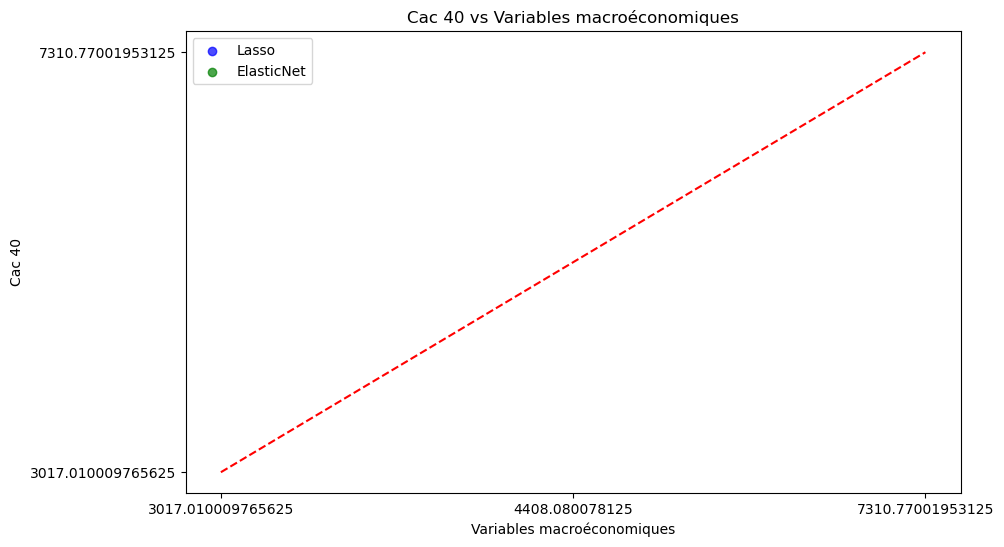

In [248]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=["Close", "trimestre"])
y = df["Close"]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Recherche de l'alpha optimal pour Lasso avec validation croisée
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 200]}
lasso_cv = GridSearchCV(Lasso(max_iter=5000, random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha pour Lasso : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Entraînement du modèle Lasso avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, max_iter=5000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Calcul des métriques pour Lasso
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso)
n, p = X_test.shape
r2_adjusted_lasso = 1 - ((1 - r2_lasso) * (n - 1) / (n - p - 1))

print(f"Lasso - RMSE: {rmse_lasso}")
print(f"Lasso - R²: {r2_lasso}")
print(f"Lasso - R² ajusté: {r2_adjusted_lasso}")

# Affichage des coefficients Lasso
# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,  # Utiliser les colonnes de X
    "Coefficient": lasso.coef_
})

print("Variables sélectionnées par Lasso :")
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Affiche uniquement les variables sélectionnées


# Tester ElasticNet en cas de convergence difficile pour Lasso
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=0.5, max_iter=5000, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_enet = elastic_net.predict(X_test)

# Calcul des métriques pour ElasticNet
r2_enet = r2_score(y_test, y_pred_enet)
rmse_enet = mean_squared_error(y_test, y_pred_enet)
r2_adjusted_enet = 1 - ((1 - r2_enet) * (n - 1) / (n - p - 1))

print(f"ElasticNet - RMSE: {rmse_enet}")
print(f"ElasticNet - R²: {r2_enet}")
print(f"ElasticNet - R² ajusté: {r2_adjusted_enet}")

# Comparaison des modèles
print("\nComparaison des performances :")
print(f"Lasso: R² = {r2_lasso}, R² ajusté = {r2_adjusted_lasso}, RMSE = {rmse_lasso}")
print(f"ElasticNet: R² = {r2_enet}, R² ajusté = {r2_adjusted_enet}, RMSE = {rmse_enet}")

# Visualisation des prédictions (facultatif)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.7, label="Lasso", color='blue')
plt.scatter(y_test, y_pred_enet, alpha=0.7, label="ElasticNet", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Variables macroéconomiques')
plt.ylabel('Cac 40')
plt.title('Cac 40 vs Variables macroéconomiques')
plt.legend()
plt.show()


L'absence de points bleu ou vert nous montrent que les regressions ne prédisent pas bien le cac40 à partir des variables macroéconomiques. Nous allons à présent tester une série temporelle. 